In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

In [3]:
N, D = 50, 10
d = 1
relevant_dim = [1]
X = np.random.randn(N, D)
true_coef = pd.Series(np.zeros(D), index=[f"d{i}" for i in range(D)])
true_coef[relevant_dim] = np.random.randn(d) / np.sqrt(d)

true_response = X.dot(true_coef)
true_response_var = (true_coef ** 2).sum()

y = true_response + np.random.randn(N)

In [4]:
data = pd.DataFrame(X, columns=[f"d{i}" for i in range(D)])
data["response"] = y

In [5]:
X.shape

(50, 10)

In [6]:
with pm.Model() as pm_model:
    w_prior = pm.Dirichlet("w", a=[1, 1])
    beta = pm.NormalMixture("beta", w=w_prior, mu=[0, 0], sigma=[0.1, 4.5], shape=D)

    sigma = pm.HalfStudentT("sigma", nu=4, sigma=2)
    pm.Normal("y", mu=pm.math.dot(X, beta), sigma=sigma, observed=y)
    tr = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, beta, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


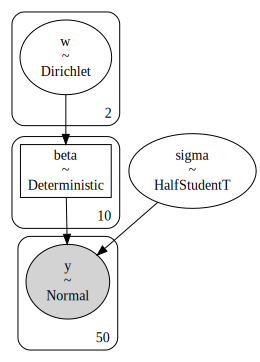

In [7]:
pm.model_to_graphviz(pm_model)

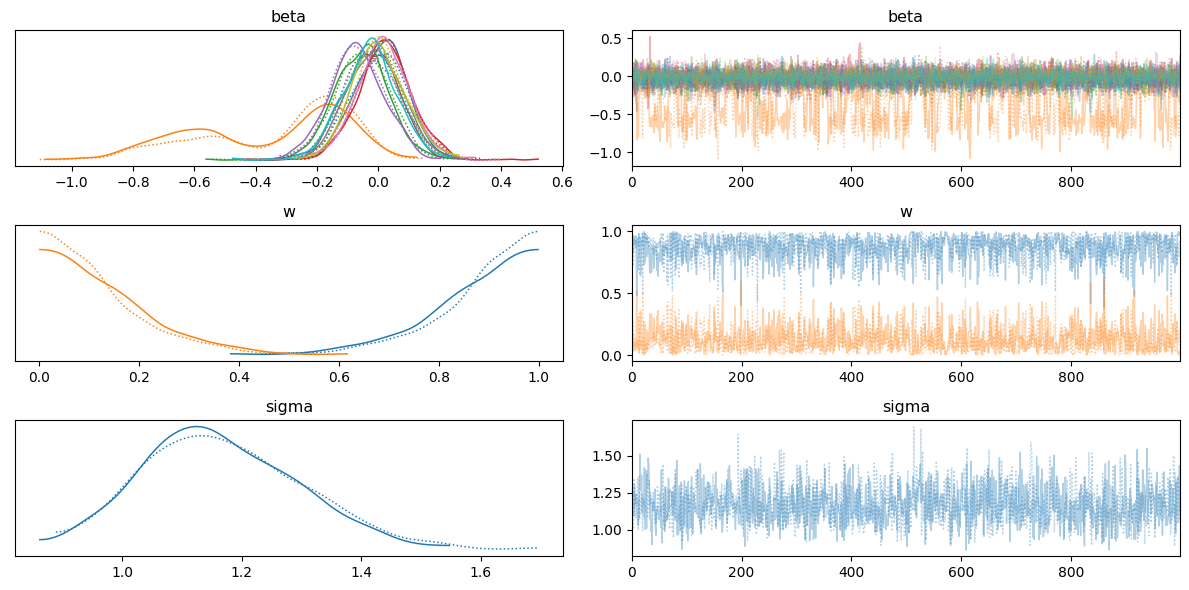

In [8]:
az.plot_trace(tr)
plt.tight_layout()
s = az.summary(tr)

In [9]:
s["true_value"] = np.nan
s["true_value"].iloc[:D] = true_coef.values
s

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,true_value
beta[0],0.006,0.088,-0.157,0.168,0.002,0.002,2335.0,1392.0,1.0,0.000000
beta[1],-0.341,0.249,-0.800,0.004,0.014,0.010,438.0,1552.0,1.0,-0.290521
beta[2],-0.054,0.094,-0.217,0.124,0.002,0.002,2350.0,1285.0,1.0,0.000000
beta[3],0.022,0.089,-0.157,0.180,0.002,0.002,2827.0,1396.0,1.0,0.000000
beta[4],-0.069,0.089,-0.224,0.103,0.002,0.002,2377.0,1234.0,1.0,0.000000
beta[5],-0.025,0.092,-0.191,0.142,0.002,0.002,3474.0,1293.0,1.0,0.000000
beta[6],0.015,0.089,-0.149,0.185,0.001,0.002,3896.0,1623.0,1.0,0.000000
beta[7],-0.012,0.087,-0.173,0.153,0.002,0.002,3124.0,1300.0,1.0,0.000000
beta[8],0.004,0.087,-0.167,0.162,0.002,0.002,2130.0,1317.0,1.0,0.000000
beta[9],-0.026,0.090,-0.188,0.137,0.002,0.002,2570.0,1388.0,1.0,0.000000


In [10]:
formula = "response ~ 0 + c(" + ", ".join([f"d{i}" for i in range(10)]) + ")"
bmb_model = bmb.Model(formula, data)
w_prior = bmb.Prior("Dirichlet", a=np.array([1.0, 1.0]))
subject_prior = bmb.Prior("NormalMixture", w=w_prior, mu=[0, 0], sigma=[0.1, 4.5])
sigma_prior = bmb.Prior("HalfStudentT", nu=4, sigma=2)
bmb_model.set_priors(dict(sigma=sigma_prior), common=subject_prior)
bmb_model

Formula: response ~ 0 + c(d0, d1, d2, d3, d4, d5, d6, d7, d8, d9)
Family name: Gaussian
Link: identity
Observations: 50
Priors:
  Common-level effects
    c(d0, d1, d2, d3, d4, d5, d6, d7, d8, d9) ~ NormalMixture(w: Dirichlet(a: [1. 1.]), mu: [0 0], sigma: [0.1 4.5])

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 2)

In [11]:
bmb_model.set_alias({"c(d0, d1, d2, d3, d4, d5, d6, d7, d8, d9)": "beta"})

In [12]:
bmb_model.build()

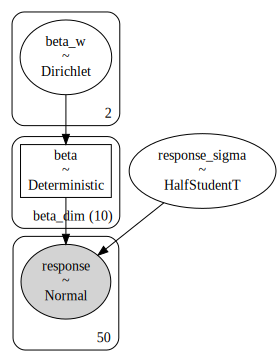

In [13]:
bmb_model.graph()

In [14]:
bmb_idata = bmb_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_w, beta, response_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


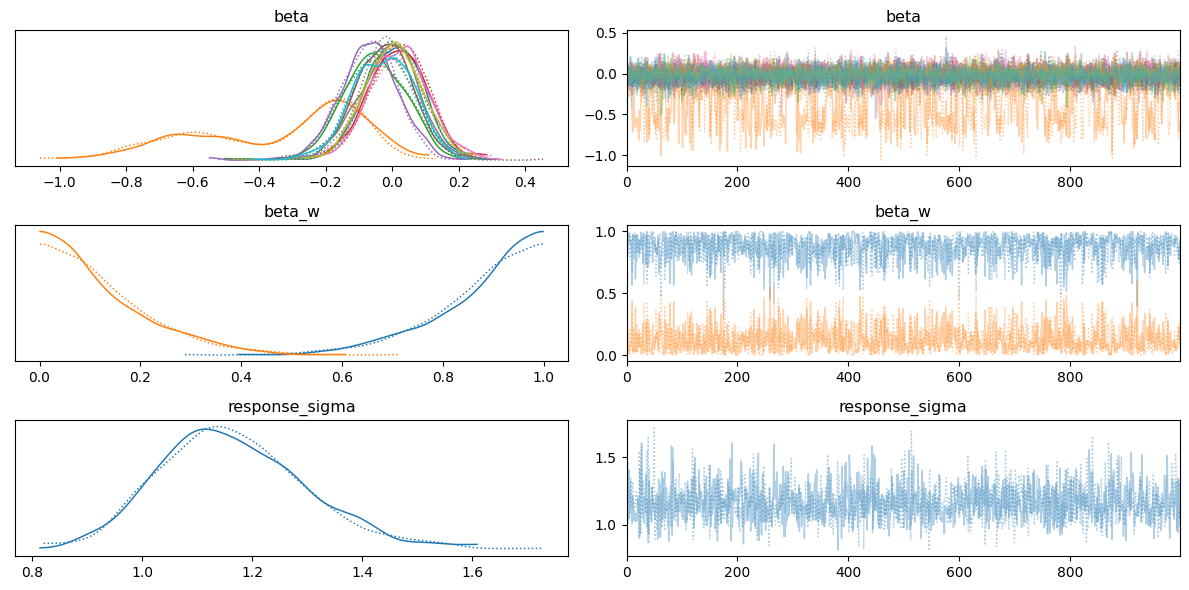

In [15]:
az.plot_trace(bmb_idata)
plt.tight_layout()